#notebook setup

In [0]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [1]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 40kB/s 
     |████████████████████████████████| 3.8MB 46.0MB/s 
     |████████████████████████████████| 450kB 69.3MB/s 
     |████████████████████████████████| 81kB 15.7MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [6]:
%cd drive/'My Drive/lhc_durham'
!pwd

/content/drive/My Drive/lhc_durham
/content/drive/My Drive/lhc_durham


In [7]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [8]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/lhc_durham/filtered_im...      2
1  /content/drive/My Drive/lhc_durham/filtered_im...      1
2  /content/drive/My Drive/lhc_durham/filtered_im...      1
3  /content/drive/My Drive/lhc_durham/filtered_im...      2
4  /content/drive/My Drive/lhc_durham/filtered_im...      1
3600


filename    object
class        int64
dtype: object

In [9]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [10]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [15]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# InceptionV3

## Entirely frozen

In [17]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

87916544/87910968 [==============================] - 4s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [20]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
activation

In [21]:
for layer in base_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_2  Trainable = False
conv2d_94  Trainable = False
batch_normalization_94  Trainable = False
activation_94  Trainable = False
conv2d_95  Trainable = False
batch_normalization_95  Trainable = False
activation_95  Trainable = False
conv2d_96  Trainable = False
batch_normalization_96  Trainable = False
activation_96  Trainable = False
max_pooling2d_4  Trainable = False
conv2d_97  Trainable = False
batch_normalization_97  Trainable = False
activation_97  Trainable = False
conv2d_98  Trainable = False
batch_normalization_98  Trainable = False
activation_98  Trainable = False
max_pooling2d_5  Trainable = False
conv2d_102  Trainable = False
batch_normalization_102  Trainable = False
activation_102  Trainable = False
conv2d_100  Trainable = False
conv2d_103  Trainable = False
batch_normalization_100  Trainable = False
batch_normalization_103  Trainable = False
activation_100  Trainable = False
activation_103  Trainable = False
average_pooling2d_9  Trainable = False
conv2d_99  Trainable = 

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
base_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [23]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

incepv3_model_filepath = 'entirely_frozen_incepv3_rms.h5'
mcp = ModelCheckpoint(incepv3_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_incepv3_history = base_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 897s 37s/step - loss: 1.0448 - accuracy: 0.4531 - val_loss: 11.8436 - val_accuracy: 0.4000
Epoch 2/50
24/24 [==============================] - 10s 429ms/step - loss: 0.8863 - accuracy: 0.5889 - val_loss: 13.7242 - val_accuracy: 0.4306
Epoch 3/50
24/24 [==============================] - 10s 423ms/step - loss: 0.7940 - accuracy: 0.6396 - val_loss: 27.4880 - val_accuracy: 0.3278
Epoch 4/50
24/24 [==============================] - 10s 419ms/step - loss: 0.7319 - accuracy: 0.6785 - val_loss: 17.8628 - val_accuracy: 0.4028
Epoch 5/50
24/24 [==============================] - 10s 420ms/step - loss: 0.7024 - accuracy: 0.6965 - val_loss: 34.9171 - val_accuracy: 0.3139
Epoch 6/50
24/24 [==============================] - 11s 444ms/step - loss: 0.6703 - accuracy: 0.7087 - val_loss: 29.8742 - val_accuracy: 0.3194
Epoch 7/50
24/24 [==============================] - 10s 422ms/step 

#### testing the model

In [24]:
test_steps = int(len(df_test)/batch_size)

metrics = base_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 98s 33s/step - loss: 175.0406 - accuracy: 0.3333
model accuracy: 0.33333334


#### plotting training

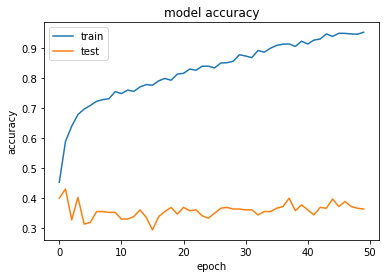

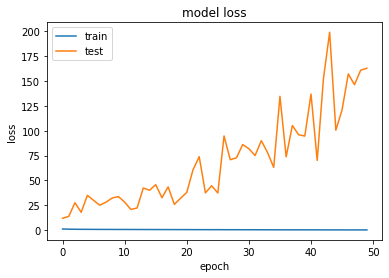

In [25]:
plot_hist(entirely_frozen_incepv3_history, 'entirely_frozen_incepV3_rms')

#### saving the history of the fitting

In [26]:

with open(cwd + '/trainHistoryDict/basic_incepV3_rms_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [30]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200
activa

#### calculating which layers to train

In [31]:
trainable_count = 0
per_layers = 0.2
num_model_layers = len(base_incepv3.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.20257234726688103


#### setting layers to train

In [0]:
#few_unfrozen_incepv3_model.trainable = True


set_trainable = False
for idx, layer in enumerate(base_incepv3.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

#print('percent unfrozen:', trainable_count/ len(few_unfrozen_incepv3_model.layers) * 100 , '%')

In [33]:
for layer in few_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_3 False
conv2d_188 False
batch_normalization_188 False
activation_188 False
conv2d_189 False
batch_normalization_189 False
activation_189 False
conv2d_190 False
batch_normalization_190 False
activation_190 False
max_pooling2d_8 False
conv2d_191 False
batch_normalization_191 False
activation_191 False
conv2d_192 False
batch_normalization_192 False
activation_192 False
max_pooling2d_9 False
conv2d_196 False
batch_normalization_196 False
activation_196 False
conv2d_194 False
conv2d_197 False
batch_normalization_194 False
batch_normalization_197 False
activation_194 False
activation_197 False
average_pooling2d_18 False
conv2d_193 False
conv2d_195 False
conv2d_198 False
conv2d_199 False
batch_normalization_193 False
batch_normalization_195 False
batch_normalization_198 False
batch_normalization_199 False
activation_193 False
activation_195 False
activation_198 False
activation_199 False
mixed0 False
conv2d_203 False
batch_normalization_203 False
activation_203 False
conv2d_201 False
c

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [35]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_incepv3_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_incepv3_history = few_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 17s 715ms/step - loss: 0.7985 - accuracy: 0.6319 - val_loss: 25.5433 - val_accuracy: 0.3389
Epoch 2/50
24/24 [==============================] - 11s 465ms/step - loss: 0.4882 - accuracy: 0.7917 - val_loss: 31.7775 - val_accuracy: 0.3278
Epoch 3/50
24/24 [==============================] - 11s 467ms/step - loss: 0.3090 - accuracy: 0.8694 - val_loss: 55.2602 - val_accuracy: 0.3444
Epoch 4/50
24/24 [==============================] - 11s 454ms/step - loss: 0.1374 - accuracy: 0.9500 - val_loss: 61.1773 - val_accuracy: 0.4056
Epoch 5/50
24/24 [==============================] - 11s 459ms/step - loss: 0.0591 - accuracy: 0.9806 - val_loss: 61.0095 - val_accuracy: 0.3972
Epoch 6/50
24/24 [==============================] - 11s 457ms/step - loss: 0.0224 - accuracy: 0.9937 - val_loss: 105.0983 - val_accuracy: 0.4028
Epoch 7/50
24/24 [==============================] - 11s 455ms/ste

#### testing the model

In [36]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 343ms/step - loss: 341.2535 - accuracy: 0.3028
model accuracy: 0.30277777


#### plotting training

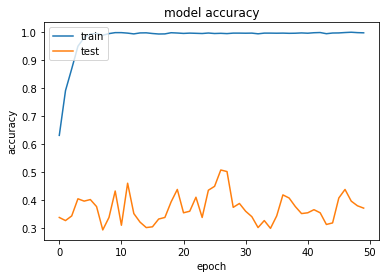

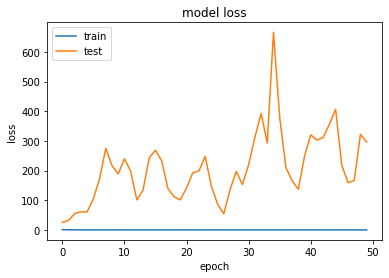

In [37]:
plot_hist(few_unfrozen_incepv3_history, 'few_unfrozen_incepV3_rms')

#### saving the history of the fitting

In [38]:
with open(cwd + '/trainHistoryDict/few_unfrozen_incepv3_rms_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [42]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_4
conv2d_282
batch_normalization_282
activation_282
conv2d_283
batch_normalization_283
activation_283
conv2d_284
batch_normalization_284
activation_284
max_pooling2d_12
conv2d_285
batch_normalization_285
activation_285
conv2d_286
batch_normalization_286
activation_286
max_pooling2d_13
conv2d_290
batch_normalization_290
activation_290
conv2d_288
conv2d_291
batch_normalization_288
batch_normalization_291
activation_288
activation_291
average_pooling2d_27
conv2d_287
conv2d_289
conv2d_292
conv2d_293
batch_normalization_287
batch_normalization_289
batch_normalization_292
batch_normalization_293
activation_287
activation_289
activation_292
activation_293
mixed0
conv2d_297
batch_normalization_297
activation_297
conv2d_295
conv2d_298
batch_normalization_295
batch_normalization_298
activation_295
activation_298
average_pooling2d_28
conv2d_294
conv2d_296
conv2d_299
conv2d_300
batch_normalization_294
batch_normalization_296
batch_normalization_299
batch_normalization_300
activation_294
acti

#### calculating which layers to train

In [43]:
trainable_count = 0
per_layers = 0.7
num_model_layers = len(base_incepv3.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.7009646302250804


#### setting which layers to train

In [0]:
set_trainable = False
for idx, layer in enumerate(base_incepv3.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

In [45]:
for layer in many_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_4 False
conv2d_282 False
batch_normalization_282 False
activation_282 False
conv2d_283 False
batch_normalization_283 False
activation_283 False
conv2d_284 False
batch_normalization_284 False
activation_284 False
max_pooling2d_12 False
conv2d_285 False
batch_normalization_285 False
activation_285 False
conv2d_286 False
batch_normalization_286 False
activation_286 False
max_pooling2d_13 False
conv2d_290 False
batch_normalization_290 False
activation_290 False
conv2d_288 False
conv2d_291 False
batch_normalization_288 False
batch_normalization_291 False
activation_288 False
activation_291 False
average_pooling2d_27 False
conv2d_287 False
conv2d_289 False
conv2d_292 False
conv2d_293 False
batch_normalization_287 False
batch_normalization_289 False
batch_normalization_292 False
batch_normalization_293 False
activation_287 False
activation_289 False
activation_292 False
activation_293 False
mixed0 False
conv2d_297 False
batch_normalization_297 False
activation_297 False
conv2d_295 False

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [47]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_incepv3_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_incepv3_history = many_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 23s 956ms/step - loss: 0.7581 - accuracy: 0.6490 - val_loss: 39.3211 - val_accuracy: 0.3389
Epoch 2/50
24/24 [==============================] - 14s 574ms/step - loss: 0.4735 - accuracy: 0.7868 - val_loss: 108.5120 - val_accuracy: 0.3417
Epoch 3/50
24/24 [==============================] - 15s 615ms/step - loss: 0.3312 - accuracy: 0.8552 - val_loss: 135.0385 - val_accuracy: 0.3389
Epoch 4/50
24/24 [==============================] - 14s 570ms/step - loss: 0.2140 - accuracy: 0.9170 - val_loss: 138.0745 - val_accuracy: 0.3639
Epoch 5/50
24/24 [==============================] - 14s 579ms/step - loss: 0.1275 - accuracy: 0.9524 - val_loss: 117.7267 - val_accuracy: 0.4222
Epoch 6/50
24/24 [==============================] - 14s 570ms/step - loss: 0.0973 - accuracy: 0.9663 - val_loss: 261.2128 - val_accuracy: 0.5000
Epoch 7/50
24/24 [==============================] - 14s 579ms

#### testing the model

In [48]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 333ms/step - loss: 43729.5573 - accuracy: 0.3361
model accuracy: 0.3361111


#### plotting training

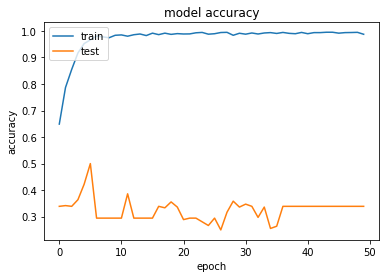

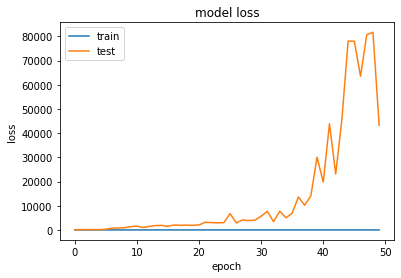

In [49]:
plot_hist(many_unfrozen_incepv3_history, 'many_unfrozen_incepV3_rms')

#### saving the history of the fitting

In [50]:
with open(cwd + '/trainHistoryDict/many_unfrozen_incepv3_rms_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [54]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name)
    layer.trainable = True

input_5
conv2d_376
batch_normalization_376
activation_376
conv2d_377
batch_normalization_377
activation_377
conv2d_378
batch_normalization_378
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_379
activation_379
conv2d_380
batch_normalization_380
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_384
activation_384
conv2d_382
conv2d_385
batch_normalization_382
batch_normalization_385
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_381
batch_normalization_383
batch_normalization_386
batch_normalization_387
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_391
activation_391
conv2d_389
conv2d_392
batch_normalization_389
batch_normalization_392
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_388
batch_normalization_390
batch_normalization_393
batch_normalization_394
activation_388
acti

In [55]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_5  Trainable = True
conv2d_376  Trainable = True
batch_normalization_376  Trainable = True
activation_376  Trainable = True
conv2d_377  Trainable = True
batch_normalization_377  Trainable = True
activation_377  Trainable = True
conv2d_378  Trainable = True
batch_normalization_378  Trainable = True
activation_378  Trainable = True
max_pooling2d_16  Trainable = True
conv2d_379  Trainable = True
batch_normalization_379  Trainable = True
activation_379  Trainable = True
conv2d_380  Trainable = True
batch_normalization_380  Trainable = True
activation_380  Trainable = True
max_pooling2d_17  Trainable = True
conv2d_384  Trainable = True
batch_normalization_384  Trainable = True
activation_384  Trainable = True
conv2d_382  Trainable = True
conv2d_385  Trainable = True
batch_normalization_382  Trainable = True
batch_normalization_385  Trainable = True
activation_382  Trainable = True
activation_385  Trainable = True
average_pooling2d_36  Trainable = True
conv2d_381  Trainable = True
conv

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [57]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_incepv3_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_incepv3_history = unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 29s 1s/step - loss: 0.7266 - accuracy: 0.6587 - val_loss: 3.2428 - val_accuracy: 0.2944
Epoch 2/50
24/24 [==============================] - 18s 763ms/step - loss: 0.4909 - accuracy: 0.7858 - val_loss: 2.8512 - val_accuracy: 0.2750
Epoch 3/50
24/24 [==============================] - 18s 770ms/step - loss: 0.3774 - accuracy: 0.8385 - val_loss: 5.9578 - val_accuracy: 0.2944
Epoch 4/50
24/24 [==============================] - 18s 753ms/step - loss: 0.2643 - accuracy: 0.8931 - val_loss: 6.0392 - val_accuracy: 0.2917
Epoch 5/50
24/24 [==============================] - 18s 757ms/step - loss: 0.1820 - accuracy: 0.9212 - val_loss: 2.8325 - val_accuracy: 0.2722
Epoch 6/50
24/24 [==============================] - 18s 748ms/step - loss: 0.1418 - accuracy: 0.9493 - val_loss: 2.1733 - val_accuracy: 0.3250
Epoch 7/50
24/24 [==============================] - 18s 763ms/step - loss: 

#### testing the model

In [60]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 371ms/step - loss: 4.1591 - accuracy: 0.7056
model accuracy: 0.70555556


#### plotting training

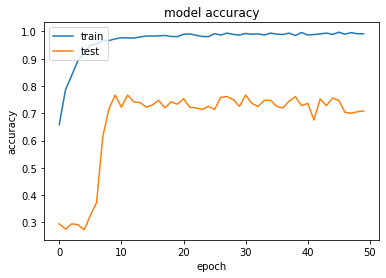

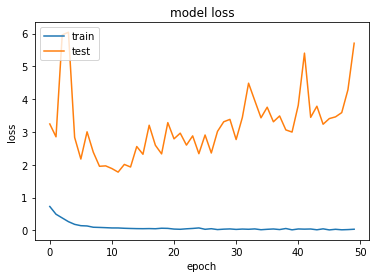

In [61]:
plot_hist(unfrozen_incepv3_history, 'unfrozen_incepV3_rms')

#### saving the history of the fitting

In [59]:
with open(cwd + '/trainHistoryDict/unfrozen_incepv3_rms_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved
